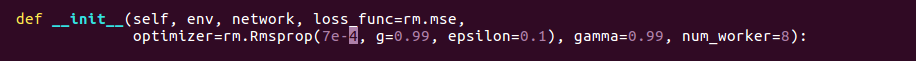

In [1]:
import gym
import numpy as np
import renom as rm
from renom.cuda import set_cuda_active
from renom_rl.a3c import A3C
from renom_rl.env import BaseEnv
from gym.core import Env
from PIL import Image

set_cuda_active(True)
env = gym.make('BreakoutNoFrameskip-v4')

class CustomEnv(BaseEnv):
    
    def __init__(self, env):
        self.env = env
        self.action_shape = 4
        self.state_shape = (4, 84, 84)
        self.previous_frames = []
        super(CustomEnv, self).__init__()
    
    def reset(self):
        self.env.reset()
        n_step = np.random.randint(4, 32+1)
        for _ in range(n_step):
            state, _, _ = self.step(self.env.action_space.sample())
        return state
    
    def sample(self):
        return self.env.action_space.sample()
    
    def render(self):
        self.env.render()

    def _preprocess(self, state):
        resized_image = Image.fromarray(state).resize((84, 110)).convert('L')
        image_array = np.asarray(resized_image)/255.
        final_image = image_array[26:110]
        # Confirm that the image is processed correctly.
        # Image.fromarray(np.clip(final_image.reshape(84, 84)*255, 0, 255).astype(np.uint8)).save("test.png")
        return final_image
    
    def step(self, action):
        state_list = []
        reward_list = []
        terminal = False
        for _ in range(4):
            # Use last frame. Other frames will be skipped.
            
            s, r, t, _ = self.env.step(action)
            state = self._preprocess(s)
            reward_list.append(r)
            if t:
                terminal = True
                
        if len(self.previous_frames) > 3:
            self.previous_frames = self.previous_frames[1:] + [state]
        else:
            self.previous_frames += [state]
        state = np.stack(self.previous_frames)
        return state, np.array(np.sum(reward_list) > 0), terminal

custom_env = CustomEnv(env)

class AC(rm.Model):
    
    def __init__(self):
        self._cv1 = rm.Conv2d(32, filter=8, stride=4)
        self._cv2 = rm.Conv2d(64, filter=4, stride=2)
        self._cv3 = rm.Conv2d(64, filter=3, stride=1)
        
        self._dn_a1 = rm.Dense(512)
        self._dn_a2 = rm.Dense(4)
        self._dn_c1 = rm.Dense(512)
        self._dn_c2 = rm.Dense(1)

    def forward(self, x):
        h = rm.relu(self._cv1(x))
        h = rm.relu(self._cv2(h))
        h = rm.relu(self._cv3(h))
        h = rm.flatten(h)
        ha = rm.relu(self._dn_a1(h))
        hc = rm.relu(self._dn_c1(h))
        p = rm.softmax(self._dn_a2(ha))
        v = self._dn_c2(hc)
        return p, v
    
nn_model = AC()

In [2]:
model = A3C(custom_env, nn_model, num_worker=8)

In [3]:
model.fit(episode=50000, episode_step=2000, test_frequency=80)

Average Train reward: 1.250 Test reward: 1.000 Greedy: 0.0040: : 80it [00:48,  2.30it/s]
Average Train reward: 0.988 Test reward: 2.000 Greedy: 0.0077: : 80it [00:44,  2.22it/s]
Average Train reward: 1.363 Test reward: 2.000 Greedy: 0.0117: : 80it [00:49,  1.96it/s]
Average Train reward: 1.462 Test reward: 1.000 Greedy: 0.0160: : 80it [00:51,  2.34it/s]
Average Train reward: 1.763 Test reward: 1.000 Greedy: 0.0206: : 80it [00:54,  2.10it/s]
Average Train reward: 1.600 Test reward: 1.000 Greedy: 0.0248: : 80it [00:50,  1.66it/s]
Average Train reward: 1.350 Test reward: 0.000 Greedy: 0.0289: : 80it [00:49,  2.07it/s]
Average Train reward: 1.425 Test reward: 3.000 Greedy: 0.0331: : 80it [00:50,  1.88it/s]
Average Train reward: 1.538 Test reward: 0.000 Greedy: 0.0373: : 80it [00:50,  1.73it/s]
Average Train reward: 1.225 Test reward: 6.000 Greedy: 0.0412: : 80it [00:48,  1.50it/s]
Average Train reward: 1.250 Test reward: 0.000 Greedy: 0.0454: : 80it [00:50,  2.31it/s]
Average Train reward:

Average Train reward: 4.000 Test reward: 6.000 Greedy: 0.9000: : 80it [01:18,  1.19it/s]
Average Train reward: 3.962 Test reward: 1.000 Greedy: 0.9000: : 80it [01:28,  1.10it/s]
Average Train reward: 4.400 Test reward: 6.000 Greedy: 0.9000: : 80it [01:35,  1.38s/it]
Average Train reward: 4.112 Test reward: 6.000 Greedy: 0.9000: : 80it [01:19,  1.07it/s]
Average Train reward: 4.050 Test reward: 1.000 Greedy: 0.9000: : 80it [01:26,  1.09it/s]
Average Train reward: 4.613 Test reward: 6.000 Greedy: 0.9000: : 80it [01:27,  1.16it/s]
Average Train reward: 3.900 Test reward: 6.000 Greedy: 0.9000: : 80it [01:18,  1.81it/s]
Average Train reward: 4.225 Test reward: 5.000 Greedy: 0.9000: : 80it [01:24,  1.45it/s]
Average Train reward: 4.213 Test reward: 7.000 Greedy: 0.9000: : 80it [01:22,  1.41it/s]
Average Train reward: 4.425 Test reward: 2.000 Greedy: 0.9000: : 80it [01:25,  1.06it/s]
Average Train reward: 4.650 Test reward: 2.000 Greedy: 0.9000: : 80it [01:29,  1.08it/s]
Average Train reward:

Average Train reward: 5.550 Test reward: 5.000 Greedy: 0.9000: : 80it [01:38,  1.18it/s]
Average Train reward: 5.412 Test reward: 7.000 Greedy: 0.9000: : 80it [01:37,  1.36it/s]
Average Train reward: 6.162 Test reward: 5.000 Greedy: 0.9000: : 80it [01:50,  1.12it/s]
Average Train reward: 5.825 Test reward: 7.000 Greedy: 0.9000: : 80it [01:43,  1.51it/s]
Average Train reward: 6.112 Test reward: 9.000 Greedy: 0.9000: : 80it [01:46,  1.24it/s]
Average Train reward: 5.662 Test reward: 6.000 Greedy: 0.9000: : 80it [01:41,  1.31it/s]
Average Train reward: 5.500 Test reward: 6.000 Greedy: 0.9000: : 80it [01:37,  1.06it/s]
Average Train reward: 5.650 Test reward: 5.000 Greedy: 0.9000: : 80it [01:40,  1.13it/s]
Average Train reward: 5.975 Test reward: 5.000 Greedy: 0.9000: : 80it [01:44,  1.00it/s]
Average Train reward: 5.763 Test reward: 7.000 Greedy: 0.9000: : 80it [01:41,  1.74it/s]
Average Train reward: 5.912 Test reward: 6.000 Greedy: 0.9000: : 80it [01:44,  1.27it/s]
Average Train reward:

Average Train reward: 6.037 Test reward: 7.000 Greedy: 0.9000: : 80it [01:44,  1.29it/s]
Average Train reward: 6.438 Test reward: 5.000 Greedy: 0.9000: : 80it [01:52,  1.28it/s]
Average Train reward: 6.513 Test reward: 13.000 Greedy: 0.9000: : 80it [01:56,  1.33it/s]
Average Train reward: 6.412 Test reward: 12.000 Greedy: 0.9000: : 80it [01:52,  1.10it/s]
Average Train reward: 6.463 Test reward: 9.000 Greedy: 0.9000: : 80it [01:55,  1.36it/s]
Average Train reward: 6.825 Test reward: 12.000 Greedy: 0.9000: : 80it [01:57,  1.05s/it]
41it [01:02,  1.82s/it]ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ubuntu/.virtualenvs/python35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-5ae6dd7aee38>", line 1, in <module>
    model.fit(episode=50000, episode_step=2000, test_frequency=80)
  File "/home/ubuntu/Documents/local_repository/ReNomRL/renom_rl/a3c.py", line 189, in fit
    result = exc.map(run_agent, self.envs)
  File "/usr/lib/python3.5/concurrent/futures/_base.py", line 581, in __exit__
    self.shutdown(wait=True)
  File "/usr/lib/python3.5/concurrent/futures/thread.py", line 139, in shutdown
    t.join()
  File "/usr/lib/python3.5/threading.py", line 1054, in join
    self._wait_for_tstate_lock()
  File "/usr/lib/python3.5/threading.py", line 1070, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most rece

KeyboardInterrupt: 

50it [01:16,  1.66s/it]

In [ ]:
import time
start_t = time.time()
a = np.random.permutation(int(1e1))
print(time.time()-start_t)

#### 

In [ ]:
model.test(render=True)